In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error,mean_squared_log_error,confusion_matrix,accuracy_score
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from math import sqrt
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

### Data Loading

In [2]:
df_training = pd.read_csv("df_training_scholarjet.csv")
df_training.head()


,Unnamed: 0,cuid,convert_30,revenue_30,roll_up,currentstatus,companytypegroup,team,customersource,accrole,...,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,1,20,0,0.0,Onboarding,Active,Business,US,External Application,None,...,0.000000,0.0,0.0,0.0,0.190476,0.000000,0.000000,3.000000,1.0,17
1,2,57,0,0.0,Onboarding,Active,Business,US,Internal Application,None,...,0.020000,0.0,0.0,0.0,0.040000,0.000000,0.020000,3.000000,1.0,70
2,3,163,0,0.0,Onboarding,Active,Business,US,Internal Application,None,...,0.106195,0.0,0.0,0.0,0.000000,0.000000,0.001770,13.000000,1.0,27
3,4,167,0,0.0,Onboarding,Enrolled,Business,US,Internal Customer Scrape,None,...,0.100000,0.0,0.0,0.0,0.000000,0.000000,0.100000,NaN,NaN,25
4,5,168,0,0.0,Onboarding,Enrolled,Business,US,Gateway,None,...,0.072072,0.0,0.0,0.0,0.009524,0.016807,0.003465,8.333333,3.0,33


In [3]:
Targets = df_training[['convert_30','revenue_30']]
X = df_training.drop(["convert_30", "revenue_30"], axis=1)

### Data Cleaning

In [4]:
categorical_list = []
numerical_list = []
for i in df_training.columns.tolist():
    if df_training[i].dtype=='object':
        categorical_list.append(i)
    else:
        if i not in ['cuid','convert_30','revenue_30','Unnamed: 0']:
            numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 10
Number of numerical features: 170


In [5]:
categorical_list

['roll_up',
 'currentstatus',
 'companytypegroup',
 'team',
 'customersource',
 'accrole',
 'num_employees',
 'num_purchases_year',
 'cost_purchases_year',
 'enrollmentmethod']

#### 1. Check for Missing Values

In [6]:
print (df_training.isnull().sum())

Unnamed: 0                          0
cuid                                0
convert_30                          0
revenue_30                          0
roll_up                             0
currentstatus                       0
companytypegroup                    0
team                                0
customersource                      0
accrole                             0
num_employees                       0
num_purchases_year                  0
cost_purchases_year                 0
enrollmentmethod                    0
numorderone                     18424
numorderthreeone                18424
numorderseventhree              18424
numorderthirtyseven             18424
numordersixtythirty             18424
numorderyearsixty               18424
sumrevone                       18424
sumrevthreeone                  18424
sumrevseventhree                18424
sumrevthirtyseven               18426
sumrevsixtythirty               18425
sumrevyearsixty                 18426
numbamorder 

There seems to be a lot of missing values in the numerical features. While, all the features are not going to be useful in modelling, it can be important in producing different visuals, plots and relationships.

1. One way is to simply remove all the features that contain a lot of missing values because it is cheaper for us to spend time avoiding missing data than estimating the right values and it also reduces the uncertainty of data.
2. Other way is to define a strategy and impute values based on the strategy. One of the most common ones is using a median value or simply replacing it with a 0 value.

#### Univariate Feature Imputation

The SimpleImputer class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.

In [7]:
categorical_columns = []
numeric_columns = []
for c in df_training.columns:
    if df_training[c].map(type).eq(str).any(): #check if there are any strings in column
        categorical_columns.append(c)
    else:
        numeric_columns.append(c)

#create two DataFrames - categorical and numerical 
data_numeric = df_training[numeric_columns]
data_categorical = pd.DataFrame(df_training[categorical_columns])

#Impute missing values in the numerical features
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
data_numeric = pd.DataFrame(imp.fit_transform(data_numeric), columns = data_numeric.columns) #only apply imputer to numeric columns

#No missing values in the categorical features as per the initial investigation 

#join the two masked dataframes back together
data_joined = pd.concat([data_numeric, data_categorical], axis = 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
len(categorical_columns)

10

In [9]:
print (data_joined.isnull().sum())

Unnamed: 0                     0
cuid                           0
convert_30                     0
revenue_30                     0
numorderone                    0
numorderthreeone               0
numorderseventhree             0
numorderthirtyseven            0
numordersixtythirty            0
numorderyearsixty              0
sumrevone                      0
sumrevthreeone                 0
sumrevseventhree               0
sumrevthirtyseven              0
sumrevsixtythirty              0
sumrevyearsixty                0
numbamorder                    0
numselforder                   0
totalrev                       0
aov                            0
dayssincelastord               0
cuidshare                      0
numstores                      0
pospercentage                  0
numinf                         0
numinfconnect                  0
numinfphone                    0
numinfquote                    0
percentlarge                   0
percdirtythirty                0
          

#### 2. Handling Categorical Variables

https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/

In [10]:
print(pd.unique(data_joined['num_employees']))
print(pd.unique(data_joined['num_purchases_year']))
print(pd.unique(data_joined['cost_purchases_year']))

['50plus' '2to5' '1' '6to10' 'None' '11to50']
['1to2' '25plus' '3to5' '11to25' 'None' '6to10']
['lessthan1' '25to100' '1to5' '5to25' 'None' '100plus']


#### 1. Dummy Encoding 

In [11]:
data_joined.num_employees = data_joined.num_employees.replace({"None":0,"1":1,"2to5":4,"6to10":8,"11to50":32,"50plus":60})
data_joined.num_purchases_year = data_joined.num_purchases_year.replace({'1to2':1, '25plus':32, '3to5':4, '11to25':16, 'None':0, '6to10':8})
data_joined.cost_purchases_year = data_joined.cost_purchases_year.replace({'lessthan1':1, '25to100':64, '1to5':4, '5to25':16, 'None':0, '100plus':126})


#### 2. One-Hot Encoding 

In [12]:
onehot_data = pd.get_dummies(data_joined, drop_first=True)

In [13]:
onehot_data.columns

Index(['Unnamed: 0', 'cuid', 'convert_30', 'revenue_30', 'numorderone',
       'numorderthreeone', 'numorderseventhree', 'numorderthirtyseven',
       'numordersixtythirty', 'numorderyearsixty',
       ...
       'customersource_Self ID', 'customersource_Social - Paid',
       'accrole_Other', 'accrole_Primary', 'accrole_Purchaser',
       'enrollmentmethod_directOther', 'enrollmentmethod_email',
       'enrollmentmethod_liveTransfer', 'enrollmentmethod_other',
       'enrollmentmethod_phone'],
      dtype='object', length=207)

Now the data seems ready to use, we can check for class imbalance to remedy that before diving deep into the modelling part.

In [14]:
X = onehot_data.drop(['cuid','revenue_30','Unnamed: 0'], axis=1)
y = onehot_data.convert_30
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y, test_size=0.2, random_state=4)
X_test_class = X_test_class.drop("convert_30",axis=1)
feature_names = X_test_class.columns.tolist()

#### Check for Class Imbalance

In [15]:
x,y= X_train_class['convert_30'].value_counts()

In [16]:
x

20179

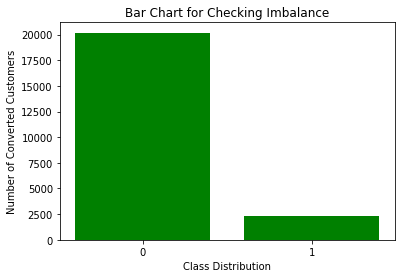

In [18]:
#plt.bar([0,1],[x, y],)
classes = ['0','1']
dist = [x,y]
plt.bar(classes,dist, color='green')
plt.title("Bar Chart for Checking Imbalance")
plt.ylabel("Number of Converted Customers")
plt.xlabel("Class Distribution")
plt.show()

#### Dealing with Class-Imbalance: Resampling Techniques 

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error. So there is a need to deal with the class imbalance before modelling. There are several techniques we've explored in the case-study that can be used in dealing with class imbalance.
 1. Over-Sampling Minority Class:
 2. Under-Sampling Majority Class:
 3. Synthetic Minority OverSampling Technique:
 

#### Over-Sampling the Minority Class

In [19]:
df_majority = X_train_class[X_train_class.convert_30==0]
df_minority = X_train_class[X_train_class.convert_30==1]
 
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples=20179, 
                                 random_state=12) 
 

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 

X_train_balance = df_upsampled.drop(['convert_30'], axis=1)
y_train_balance = df_upsampled.convert_30


### Feature-Selection Techniques

This case-study requires a lot of exploration with different feature selection techniques because:

1) There is a strong collinearity between features (as demonstrated below).
2) There are an overwhelming number of features.
3) There is a need to make the model simpler for the interpretability purposes, to reason out and tackle the business problem in such a way that there is an explanation and logical reasoning behind the important features.  

#### 1. Using Pearson's Correlation 

In [20]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_upsampled.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

<Figure size 864x720 with 0 Axes>

In [21]:
cor

,convert_30,numorderone,numorderthreeone,numorderseventhree,numorderthirtyseven,numordersixtythirty,numorderyearsixty,sumrevone,sumrevthreeone,sumrevseventhree,...,customersource_Self ID,customersource_Social - Paid,accrole_Other,accrole_Primary,accrole_Purchaser,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
convert_30,1.000000,0.083606,0.101475,0.130967,0.181592,0.127740,0.064086,0.058315,0.065629,0.075331,...,-0.008622,-0.082905,0.004260,0.007062,-0.014510,-0.041328,0.039422,0.030905,-0.093961,0.028553
numorderone,0.083606,1.000000,-0.005571,0.039872,0.025987,0.021506,-0.036492,0.621797,-0.000644,0.018471,...,-0.001054,-0.014756,-0.004983,0.002668,-0.013695,-0.012440,-0.005815,0.038827,-0.030212,0.008595
numorderthreeone,0.101475,-0.005571,1.000000,0.025928,0.051043,-0.000511,-0.056558,-0.005220,0.740182,0.012062,...,-0.001298,-0.025104,-0.006137,0.026795,0.005416,-0.012318,-0.008847,0.089527,-0.049627,0.028573
numorderseventhree,0.130967,0.039872,0.025928,1.000000,0.119817,0.067300,-0.018083,0.015380,-0.002425,0.555258,...,0.009244,-0.010434,-0.003749,-0.015770,-0.002752,-0.021860,-0.020487,0.015097,-0.053329,0.004897
numorderthirtyseven,0.181592,0.025987,0.051043,0.119817,1.000000,0.297443,0.057796,-0.006262,0.011550,0.063585,...,-0.002750,-0.047712,-0.000203,-0.021374,-0.011404,-0.009495,-0.015285,0.020752,-0.032667,-0.004290
numordersixtythirty,0.127740,0.021506,-0.000511,0.067300,0.297443,1.000000,0.241593,-0.003688,-0.006579,0.020070,...,-0.002186,-0.032898,-0.001597,-0.004915,-0.005277,-0.001645,-0.003767,0.017418,0.027970,-0.031464
numorderyearsixty,0.064086,-0.036492,-0.056558,-0.018083,0.057796,0.241593,1.000000,-0.009282,-0.050979,0.015872,...,-0.002810,-0.029631,0.029626,0.039498,0.004921,0.072923,-0.031174,-0.046923,0.186523,-0.066189
sumrevone,0.058315,0.621797,-0.005220,0.015380,-0.006262,-0.003688,-0.009282,1.000000,0.002346,0.007978,...,-0.000702,-0.015886,-0.003321,0.008210,-0.012993,-0.008930,-0.012426,0.013641,-0.020604,0.015920
sumrevthreeone,0.065629,-0.000644,0.740182,-0.002425,0.011550,-0.006579,-0.050979,0.002346,1.000000,0.001182,...,-0.000834,-0.014052,-0.003943,0.017699,0.000032,-0.017305,-0.012756,0.078132,-0.024595,0.008338
sumrevseventhree,0.075331,0.018471,0.012062,0.555258,0.063585,0.020070,0.015872,0.007978,0.001182,1.000000,...,0.001994,-0.012264,-0.003419,-0.014136,0.002960,-0.019811,-0.008621,0.038166,-0.038559,-0.020809


In [22]:
#Correlation with output variable
cor_target = abs(cor["convert_30"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

convert_30                      1.000000
dayssincelastord                0.225605
numvisitone                     0.225842
numvisitthreeone                0.257456
numvisitseventhree              0.279187
numvisitthirtyseven             0.292702
numvisitsixtythirty             0.231451
numvisittotal                   0.246942
numloggedinone                  0.207460
numloggedinthreeone             0.242205
numloggedinseventhree           0.263917
numloggedinthirtyseven          0.263903
numloggedinsixtythirty          0.201889
numsecondsonsiteseventhree      0.201602
numsecondsonsitethirtyseven     0.236587
numtotalpageviewsseventhree     0.221168
numtotalpageviewsthirtyseven    0.256707
numatcseventhree                0.202914
numatcthirtyseven               0.242652
dayssincelastvisit              0.234036
numsearchtermsthirtyseven       0.227445
numskusviewedseventhree         0.209787
numskusviewedthirtyseven        0.242284
roll_up_Unmanaged               0.242049
currentstatus_En

In [23]:
Feature_SelectionSet1= X_train_balance[['dayssincelastord', 'numvisitone','numvisitthreeone','numvisitseventhree','numvisitthirtyseven',             
'numvisitsixtythirty','numvisittotal','numloggedinone','numloggedinthreeone','numloggedinseventhree',           
'numloggedinthirtyseven','numloggedinsixtythirty', 'numsecondsonsiteseventhree' ,'numsecondsonsitethirtyseven',     
'numtotalpageviewsseventhree','numtotalpageviewsthirtyseven','numatcseventhree','numatcthirtyseven','dayssincelastvisit',              
'numsearchtermsthirtyseven','numskusviewedseventhree','numskusviewedthirtyseven','roll_up_Unmanaged','currentstatus_Enrolled'  ]] 

In [24]:
'dayssincelastord', 'numvisitone','numvisitthreeone','numvisitseventhree','numvisitthirtyseven',             
'numvisitsixtythirty','numvisittotal','numloggedinone','numloggedinthreeone','numloggedinseventhree',           
'numloggedinthirtyseven','numloggedinsixtythirty', 'numsecondsonsiteseventhree' ,'numsecondsonsitethirtyseven'     
'numtotalpageviewsseventhree','numtotalpageviewsthirtyseven','numatcseventhree','numatcthirtyseven','dayssincelastvisit',              
'numsearchtermsthirtyseven','numskusviewedseventhree','numskusviewedthirtyseven','roll_up_Unmanaged','currentstatus_Enrolled'   

('numsearchtermsthirtyseven',
 'numskusviewedseventhree',
 'numskusviewedthirtyseven',
 'roll_up_Unmanaged',
 'currentstatus_Enrolled')

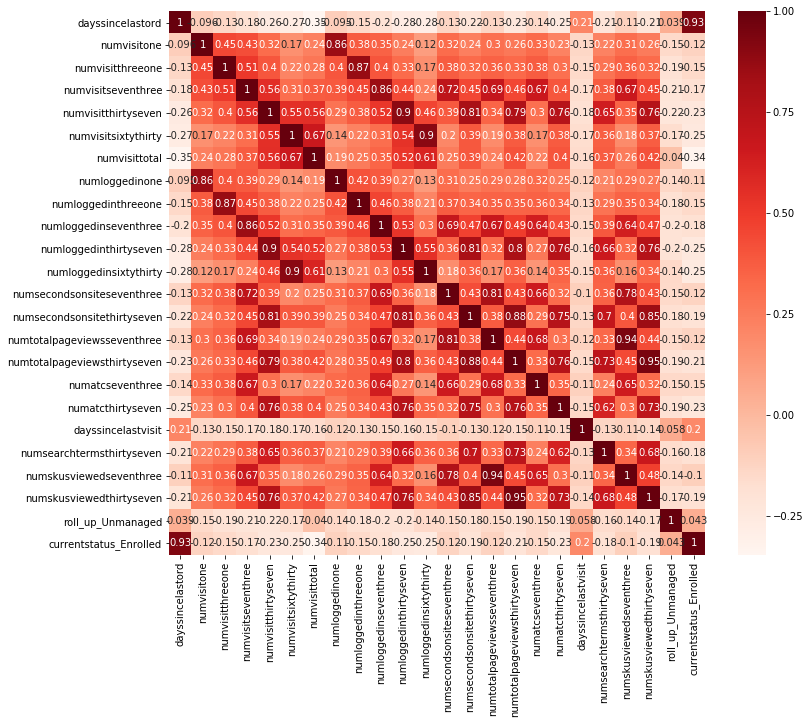

In [25]:
plt.figure(figsize=(12,10))
cor = Feature_SelectionSet1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

One of the assumptions of machine learning models is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let us check the correlation of selected features with each other. This can be done either by visually checking it from the above correlation matrix 

In [26]:
corr_matrix = cor.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

In [27]:
to_drop

['numloggedinone',
 'numloggedinthreeone',
 'numloggedinseventhree',
 'numloggedinthirtyseven',
 'numloggedinsixtythirty',
 'numsecondsonsitethirtyseven',
 'numtotalpageviewsseventhree',
 'numtotalpageviewsthirtyseven',
 'numskusviewedseventhree',
 'numskusviewedthirtyseven',
 'currentstatus_Enrolled']

In [28]:
Feature_SelectionSet1=Feature_SelectionSet1.drop(Feature_SelectionSet1[to_drop], axis=1)

In [29]:
Feature_SelectionSet1.columns

Index(['dayssincelastord', 'numvisitone', 'numvisitthreeone',
       'numvisitseventhree', 'numvisitthirtyseven', 'numvisitsixtythirty',
       'numvisittotal', 'numsecondsonsiteseventhree', 'numatcseventhree',
       'numatcthirtyseven', 'dayssincelastvisit', 'numsearchtermsthirtyseven',
       'roll_up_Unmanaged'],
      dtype='object')

#### Inference:
1) Days since last order
2) Number of online visits in the past 1 day
3) Number of online visits in the past 1-3 days
4) Number of online visits in the past 30-7 days
5) Number of online visits in the past 60-30 days
5) Number of ATCs (Add To Cart) in the past 7-3 days
6) Number of visits in the past year
7) Number of seconds on site in the past 7-3 days
8) Number of ATCc in the past 30-7 days
9) Days since last visit
10) Number of search terms in the past 30-7 days
11) rollup - unmanaged

https://www.shopify.com/enterprise/44337411-how-to-increase-your-ecommerce-conversion-rates-using-these-3-analytics-reports

#### Fitting a Baseline Logistic Regression Model

The idea is to compare the models with a variety of feature subsets to evaluate the performance across different subsets. Notice here that we've not yet diving into the modelling part or using logistic regression for the purpose of prediction.  

In [30]:
logreg = LogisticRegression()
logreg.fit(X_train_balance, y_train_balance)

y_pred = logreg.predict(X_test_class)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_class, y_test_class)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.77


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [31]:
X = Feature_SelectionSet1
y = y_train_balance
X_test = X_test_class[['dayssincelastord', 'numvisitone', 'numvisitthreeone',
       'numvisitseventhree', 'numvisitthirtyseven', 'numvisitsixtythirty',
       'numvisittotal', 'numsecondsonsiteseventhree', 'numatcseventhree',
       'numatcthirtyseven', 'dayssincelastvisit', 'numsearchtermsthirtyseven',
       'roll_up_Unmanaged']]
logreg = LogisticRegression()
logreg.fit(Feature_SelectionSet1, y_train_balance)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test_class)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.75


Notice the number of features used in both the models and the corresponding accuracy. Using 217 features, the accuracy is 77% and using 12 features, the accuracy is 75%. This does tell us a lot about the subset. Although it does not help in boosting the baseline performance, it is intuitive that most of the features in our data set are not relevant.

To further boost the performance, we explore different feature selection techniques.

#### 2. Recursive Feature Elimination 

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train_balance, y_train_balance)
print(rfe.support_)
print(rfe.ranking_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False  True False False  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False  True  True False False
 False False  True False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False  True
 False  True False False  True False False False Fa

In [36]:
ranking = print(rfe.ranking_)
rank = list(rfe.ranking_)
all_features = X_train_balance.columns.values.tolist()

[129   9 115  12  23  10  88  89  87 110  86  84  40  62  85  99 101 161
 130 169  56 124  46  32 123   1 125 127 122  38  20  11 132 117 159 147
 143 172  19  18   1 104 118   1   1   1   1   1   2   3   7  34  48  42
  51  70 102 106  98 108 135 109  63  95  73  77  78  82   1   1  14  75
  61  55   1  67   1  16  49  64  53 111  91  43  28  30  44  54  81  41
  65  60  79  69  80 103 105 113  97  96  92  90  37   8  50  22   1 114
 168 157 170 140 128 134 175 164 162 152 151 156 153 154 166 138 146 167
 179 178 181 182 183 180  26  36  45 116  29  39   1  25   4  35  13  47
  74  76  83 112 100  94 176 174 184 177 131   1  27   1  21  52   1  17
  59  15 120 141 121  72  33  66  58  93  71   5   1   1 155 173   6 145
 137 148 150 144 136 142  68   1 149 158 160 139  31 165   1 163 126 171
 107  24 133  57 119]


In [103]:
Feature_Selectionset2 =[]
for i in range(len(rank)):
    if rank[i] == 1 or rank[i] == 2:
        Feature_Selectionset2.append(all_features[i])  
        

In [104]:
Feature_Selectionset2 

['percdirtythirty',
 'quoteconrate',
 'numvisitone',
 'numvisitthreeone',
 'numvisitseventhree',
 'numvisitthirtyseven',
 'numvisitsixtythirty',
 'numvisityearsixty',
 'numatcone',
 'numatcthreeone',
 'numideaboardone',
 'numideaboardseventhree',
 'numtasksfirstintrosixtythirty',
 'numemailsone',
 'percemailopenedone',
 'percemailopenedseventhree',
 'percemailopenedyearsixty',
 'roll_up_Unmanaged',
 'currentstatus_Enrolled',
 'customersource_Internal Customer Scrape',
 'customersource_Social - Paid']

In [105]:
Feature_SelectionSet2 = X_train_balance[Feature_Selectionset2] 

In [106]:
Feature_SelectionSet2

,percdirtythirty,quoteconrate,numvisitone,numvisitthreeone,numvisitseventhree,numvisitthirtyseven,numvisitsixtythirty,numvisityearsixty,numatcone,numatcthreeone,...,numideaboardseventhree,numtasksfirstintrosixtythirty,numemailsone,percemailopenedone,percemailopenedseventhree,percemailopenedyearsixty,roll_up_Unmanaged,currentstatus_Enrolled,customersource_Internal Customer Scrape,customersource_Social - Paid
820,0.000000,0.000000,0.0,1.0,2.0,18.0,9.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,0,0
22470,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.477273,1,0,0,0
4237,0.000000,0.000000,0.0,1.0,4.0,10.0,2.0,4.0,0.0,0.0,...,1.0,0.0,0.0,1.000000,0.875000,0.000000,0,1,0,0
6984,0.000000,0.000000,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000000,0.000000,0.000000,0,1,0,0
21767,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.287293,1,1,0,0
20461,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,1,0,0
9341,1.000000,0.000000,0.0,0.0,4.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0
15557,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.035714,1,1,0,1
12489,0.000000,0.000000,0.0,0.0,3.0,11.0,17.0,273.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.428571,0.636842,0,0,0,0
17501,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.032258,1,1,1,0


In [108]:
X = Feature_Selectionset2
y = y_train_balance
X_test = X_test_class[Feature_Selectionset2]
logreg = LogisticRegression()
logreg.fit(Feature_SelectionSet2, y_train_balance)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test_class)))

Accuracy of logistic regression classifier on test set: 0.75


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 3. Ch-Squared Tests

Compute chi-squared stats between each non-negative feature and class.

This score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.

In [91]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X_train_balance)
chi_selector = SelectKBest(chi2, k=30)
chi_selector.fit(X_norm, y_train_balance)
chi_support = chi_selector.get_support()
chi_feature = X_train_balance.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

30 selected features


In [92]:
chi_feature

['dayssincelastord',
 'percdirtythirty',
 'numvisitthreeone',
 'numvisitseventhree',
 'numvisitthirtyseven',
 'numvisitsixtythirty',
 'numloggedinone',
 'numloggedinthreeone',
 'numloggedinseventhree',
 'numloggedinthirtyseven',
 'numsecondsonsiteone',
 'numsecondsonsiteseventhree',
 'numsecondsonsitethirtyseven',
 'numtotalpageviewsthirtyseven',
 'numatcone',
 'numatcthreeone',
 'numatcseventhree',
 'numatcthirtyseven',
 'numideaboardseventhree',
 'dayssincelastvisit',
 'numsearchtermsthreeone',
 'numsearchtermsthirtyseven',
 'percsecondsinbound',
 'percemailopenedone',
 'percemailopenedthreeone',
 'percemailopenedseventhree',
 'percemailopenedthirtyseven',
 'dayssinceenrollment',
 'roll_up_Unmanaged',
 'currentstatus_Enrolled']

In [93]:
Feature_SelectionSet3 = X_train_balance[chi_feature]

In [94]:
X = Feature_SelectionSet3
y = y_train_balance
X_test = X_test_class[chi_feature]
logreg = LogisticRegression()
logreg.fit(Feature_SelectionSet3, y_train_balance)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test_class)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.78
